In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
seqToDdg = {}
firstLine = True
with open("../data/experimental/GR_bindingcurves_WT_1_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        Oligo,Kd_estimate,ddG,Motif,Sequence = line.strip().split(',')
        seq = Sequence.upper()[14:32]
        pre = Sequence.upper()[:14]
        post = Sequence.upper()[32:]
        if pre != "CGCAATTGCGAGTC":
            print(pre)
            print("CGCAATTGCGAGTC")
        if post != "GACCTTCCTCTCCGGCGGTATGAC":
            print(post)
            print("GACCTTCCTCTCCGGCGGTATGAC")
        if seq not in seqToDdg:
            seqToDdg[seq] = []
        seqToDdg[seq].append(float(ddG))

firstLine = True
with open("../data/experimental/GR_bindingcurves_WT_2_out.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        Oligo,Kd_estimate,ddG,Motif,Sequence = line.strip().split(',')
        seq = Sequence.upper()[14:32]
        pre = Sequence.upper()[:14]
        post = Sequence.upper()[32:]
        if pre != "CGCAATTGCGAGTC":
            print(pre)
            print("CGCAATTGCGAGTC")
        if post != "GACCTTCCTCTCCGGCGGTATGAC":
            print(post)
            print("GACCTTCCTCTCCGGCGGTATGAC")
        seqToDdg[seq].append(float(ddG))

In [3]:
fastapath = "../data/genome/hg38/hg38.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 1346
out_pred_len = 1000
test_chrms = ["chr1", "chr8", "chr21"]
peaks = []
with gzip.open("/oak/stanford/groups/akundaje/amr1/pho4/data/a549_GR/tseries/2hr/2hr.bed.gz", 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        peaks.append(GenomeDict[chrm][start:end].upper())

In [4]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def fill_into_center(seq, insert):
    start = int((len(seq)/2.0)-(len(insert)/2.0))
    new_seq = seq[:start]+insert+seq[start+len(insert):]
    return new_seq

ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [5]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("../data/models/gr_a549_2hr_matched_model.h5")







Instructions for updating:
Use `tf.cast` instead.


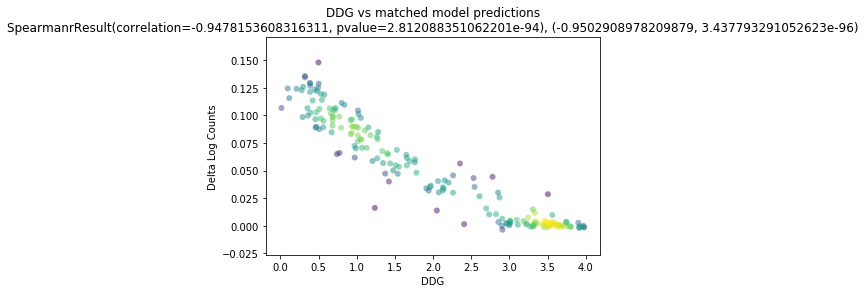

In [6]:
num_samples = 100
xvals = []
yvals = []
seqToDeltaLogCount = {}
for curr_seq in seqToDdg:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
    yvals.append(seqToDeltaLogCount[curr_seq])
    xvals.append(np.mean(seqToDdg[curr_seq]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs matched model predictions\n"+str(spearmanr(xvals, yvals))+", "+str(pearsonr(xvals, yvals)))
plt.show()

In [7]:
K.clear_session()
del model

In [8]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("../data/models/a5_tseries_model_2hr.h5")

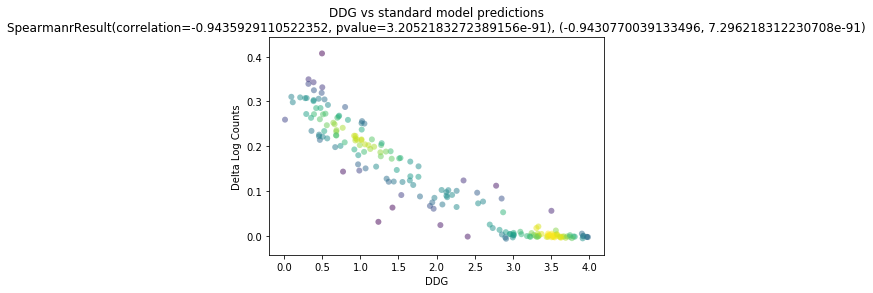

In [9]:
xvals = []
yvals = []
seqToDeltaLogCount = {}
for curr_seq in seqToDdg:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(peaks[idx])
        post_seq = fill_into_center(pre_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    seqToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])
    yvals.append(seqToDeltaLogCount[curr_seq])
    xvals.append(np.mean(seqToDdg[curr_seq]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs standard model predictions\n"+str(spearmanr(xvals, yvals))+", "+str(pearsonr(xvals, yvals)))
plt.show()